# Self-RAG Pipeline with LlamaIndex, Ollama and Groq

[**Paper**](https://arxiv.org/pdf/2310.11511) on Self-RAG

This notebook implements a **Self-Reflective Retrieval-Augmented Generation (Self-RAG)** pipeline using [`llama-index`](https://llamaindex.ai), local embedding models via **Ollama**, and a hosted LLM from **Groq (LLaMA3 70B)**.

The goal is to simulate a smart query engine that decides whether it needs to retrieve context or can directly answer a query.


## 1. Setup Language Models

We begin by initializing:
- The LLM using Groq's `llama3-70b-8192` model.
- The embedding model using Ollama's local `nomic-embed-text` for generating vector representations of text.

This forms the foundation for *semantic search* and question answering.


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from llama_index.llms.groq import Groq
llm = Groq(model="llama3-70b-8192")
from llama_index.embeddings.ollama import OllamaEmbedding
embed_model = OllamaEmbedding(
    model_name="nomic-embed-text:latest",
)

/home/itspriiyanshu/Desktop/Scylla-Agent-25/240810_Priyanshu_Ranjan/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load, Chunk, and Embed Data

We load documents from local directory using `SimpleDirectoryReader`. These documents are then embedded using the configured embedding model.

These embeddings will later be stored in a vector index for retrieval.


In [3]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("./data").load_data()

In [4]:
from llama_index.core.node_parser import SentenceSplitter
parser = SentenceSplitter(chunk_size=256, chunk_overlap=16)
nodes = parser.get_nodes_from_documents(documents)
len(nodes)

11

In [5]:
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex.from_documents(documents, embed_model=embed_model)
# index.storage_context.persist(persist_dir="./storage")

## Create Workflow
This is the heart of our implementation.
We define multiple Events(user-defined pydantic objects) to setup our workflow.

**Workflow logic:**
- Determine if retrieval is necessary or not.
- If not generate response using LLM alone.
- If retrieval is necessary, go ahead with retrieving top_3 nodes using `VectorIndexRetriever`.
- Use LLM to determine if retrieved context is relevant to query or not.
- If no context deemed relevant proceed to generate response using LLM alone.
- If relevant context found, augment it with query in a custom prompt and use it to generate response via LLM.

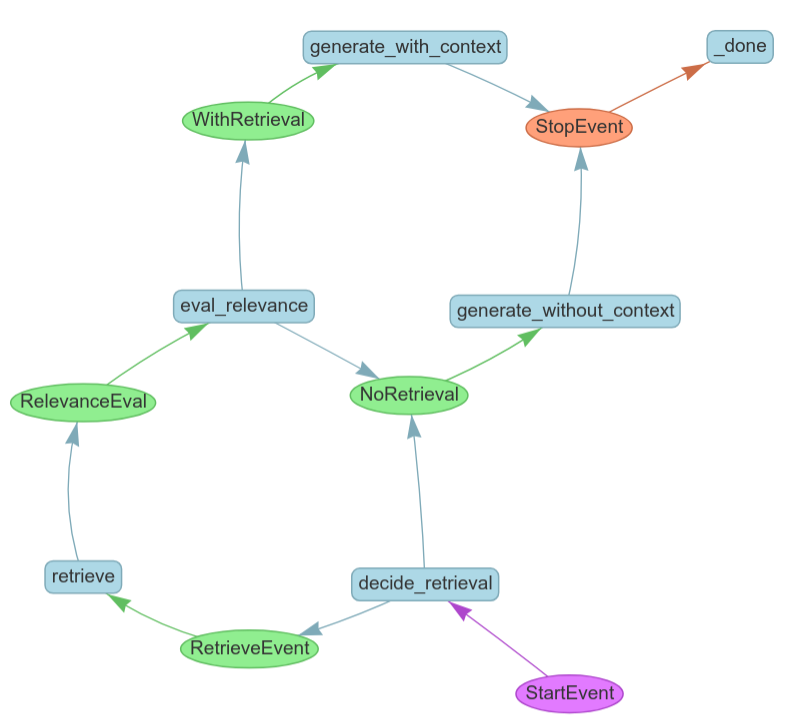

In [6]:
from IPython.display import Image, display

display(Image(filename="workflow.png"))


In [7]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
)
from llama_index.core import StorageContext, load_index_from_storage
from llama_index.core.retrievers import VectorIndexRetriever
from typing import List
from llama_index.core.schema import TextNode

In [8]:
class NoRetrieval(Event):
    query: str

class RetrieveEvent(Event):
    query: str

class RelevanceEval(Event):
    query: str
    retrieved_nodes: List[TextNode]

class WithRetrieval(Event):
    query: str
    relevant_context: List[str]

In [9]:
class sRAG(Workflow):
    @step
    async def decide_retrieval(self, ev: StartEvent) -> RetrieveEvent | NoRetrieval:
        query = ev.query

        prompt = f"Given the query: '{query}', determine if retrieval is necessary. Output only 'Yes' or 'No'."
        response = await llm.acomplete(prompt)
        if str(response)=="Yes":
            return RetrieveEvent(query=query)
        else:
            return NoRetrieval(query=query)
    @step
    async def retrieve(self, ev: RetrieveEvent) -> RelevanceEval:
        query = ev.query
        # storage_context = StorageContext.from_defaults(persist_dir="./storage", embed_model=embed_model)
        # index = load_index_from_storage(storage_context)
        retriever = VectorIndexRetriever(index=index, similarity_top_k=3)
        retrieved_nodes = retriever.retrieve(query)
        text_nodes = [n.node for n in retrieved_nodes] #try sending with scores as well and make llm leverage them evaluate relevange
        return RelevanceEval(query=query, retrieved_nodes=text_nodes)
    @step
    async def eval_relevance(self, ev: RelevanceEval) -> WithRetrieval | NoRetrieval:
        retrieved_nodes = ev.retrieved_nodes
        query = ev.query
        relevant_context = []
        for node in retrieved_nodes:
            context = node.get_content()
            prompt = f"Given the query: '{query}' and the context: '{context}', determine if the context is relevant. Output only 'Relevant' or 'Irrelevant'."
            response = await llm.acomplete(prompt)
            if str(response)=="Relevant":
                relevant_context.append(context)
        if not relevant_context:
            return NoRetrieval(query=query)
        else:
            return WithRetrieval(query=query, relevant_context=relevant_context)
    @step
    async def generate_with_context(self, ev: WithRetrieval) -> StopEvent:
        query= ev.query
        relevant_context = ev.relevant_context
        context = "\n".join(f"- {doc}" for doc in relevant_context)
        # this has a flaw, joining contexts may lead to redundant data and possible chunk overlaps
        # instead of joining contexts, we can try generating response over individual contexts 
        prompt = f"Given the query '{query}' and the context '{context}', generate a response."
        response = await llm.acomplete(prompt)
        # print(str(response))
        return StopEvent(result = str(response))
    @step
    async def generate_without_context(self, ev: NoRetrieval) -> StopEvent:
        query= ev.query
        prompt = f"Given the query '{query}', generate a response."
        response = await llm.acomplete(prompt)
        # print(str(response))
        return StopEvent(result = str(response))


# Running the Workflow

### Example where **No Retrieval** needed

In [10]:
w = sRAG(timeout=120, verbose = True)
result = await w.run(query="Write a joke")
print(str(result))

Running step decide_retrieval
Step decide_retrieval produced event NoRetrieval
Running step generate_without_context
Step generate_without_context produced event StopEvent
Here's a joke for you:

Why couldn't the bicycle stand up by itself?

Because it was two-tired!

Hope that made you laugh!


### Example where **Retrieval** needed

In [11]:
w = sRAG(timeout=120, verbose = True)
result = await w.run(query="Review for EE200A course")
print(str(result))

Running step decide_retrieval
Step decide_retrieval produced event RetrieveEvent
Running step retrieve
Step retrieve produced event RelevanceEval
Running step eval_relevance
Step eval_relevance produced event WithRetrieval
Running step generate_with_context
Step generate_with_context produced event StopEvent
Here is a response to the query "Review for EE200A course":

The EE200A course, Signals, Systems & Networks, is a challenging but rewarding course. The instructor is one of the best on campus, which makes a big difference in understanding the complex concepts. The course covers signals and their representations, system transmission, Fourier representations, and network applications. There's also some graph theory involved.

One drawback is that notes are not provided, so you'll need to take notes in class. Additionally, the assignments are lengthy, and the test questions often differ from what's asked in the assignments. However, practicing with past papers can help, even though so